In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import random
from itertools import product
from collections import Counter
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import scipy as sp

from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import log_loss, make_scorer

In [3]:
#Load the training and test data into pandas df
trainFile = r"C:\users\Jonathan\train.json"
testFile = r"C:\users\Jonathan\test.json"
trainDF = pd.read_json(trainFile)
testDF = pd.read_json(testFile)

#Create copies to mess around with columns to use in feature vectors
train = trainDF.copy()
test = testDF.copy()

print(train.shape)
train.head()

(49352, 15)


,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


In [4]:
#let's do some basic feature engineering
train['price_per_bedroom'] = train['price'] / train['bedrooms']
train['price_per_bathroom'] = train['price'] / train['bathrooms']
train['num_photos'] = train['photos'].apply(len)
train['num_features'] = train['features'].apply(len)
train['num_description_words'] = train['description'].apply(lambda x: len(x.split(" ")))
train['created'] = pd.to_datetime(train["created"])
train['created_month'] = train['created'].dt.month
train['created_day'] = train['created'].dt.day


test['price_per_bedroom'] = test['price'] / test['bedrooms']
test['price_per_bathroom'] = test['price'] / test['bathrooms']
test['num_photos'] = test['photos'].apply(len)
test['num_features'] = test['features'].apply(len)
test['num_description_words'] = test['description'].apply(lambda x: len(x.split(" ")))
test['created'] = pd.to_datetime(test["created"])
test['created_month'] = test['created'].dt.month
test['created_day'] = test['created'].dt.day


features_to_use = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
                   "price_per_bedroom", "price_per_bathroom", "num_photos", 
                   "num_features", "num_description_words",  "created_month", 
                   "created_day"]

train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,photos,price,street_address,price_per_bedroom,price_per_bathroom,num_photos,num_features,num_description_words,created_month,created_day
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,1000.0,2000.0,5,0,95,6,24
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,2732.5,5465.0,11,5,9,6,12
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,...,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,2850.0,2850.0,8,4,94,4,17
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,...,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,3275.0,3275.0,3,2,80,4,18
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,...,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street,837.5,3350.0,3,1,68,4,28


In [5]:
#let's add some binary features where we check whether a building has a particular feature or not

#function that will be used later
def newfeat(name, df, series):
    """Create a Series for my feature building loop to fill"""
    feature = pd.Series(0, df.index, name=name)
    """Now populate the new Series with numeric values"""
    for row, word in enumerate(series):
        if name in word:
            feature.iloc[row] = 1
    df[name] = feature
    return(df)

#extract feature text
feature_text = ''
for ind, row in train.iterrows():
    for feature in row['features']:
        feature_text = " ".join([feature_text, "_".join(feature.strip().split(" "))])
feature_text = feature_text.strip()
feature_text.encode('ascii', 'ignore')
feature_text = feature_text.split()

In [6]:
#get top 10 most common features
words_to_count = (word for word in feature_text if word[:1].isupper())
c = Counter(words_to_count)
topTenFeats = []
for i in range(0,10):
    topTenFeats.append(c.most_common()[i][0])
    features_to_use.append(c.most_common()[i][0])

#add binary variables on whether building has a particular top 10 feature or not
for feat in topTenFeats:
    train = newfeat(feat, train, train.features)
    test = newfeat(feat, test, test.features)

train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,Elevator,Cats_Allowed,Hardwood_Floors,Dogs_Allowed,Doorman,Dishwasher,No_Fee,Laundry_in_Building,Fitness_Center,Pre-War
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,0,0,0,0,0,0,0,0,0,0
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,1,0,0,0,1,0,0,0,0,0
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,...,0,0,0,0,0,1,0,0,0,0
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,...,0,0,0,0,0,0,0,0,0,0
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,...,0,0,0,0,0,0,0,0,0,1


In [7]:
#lastly, let's add a 'manager skill feature' that was done on kaggle by den3b 
lbl = preprocessing.LabelEncoder()
lbl.fit(list(train['manager_id'].values))
train['manager_id'] = lbl.transform(list(train['manager_id'].values))

lbl2 = preprocessing.LabelEncoder()
lbl2.fit(list(test['manager_id'].values))
test['manager_id'] = lbl2.transform(list(test['manager_id'].values))

# let's add this feature
features_to_use.append('manager_id')

In [8]:
y = train["interest_level"]

# compute fractions and count for each manager
temp_train = pd.concat([train.manager_id,pd.get_dummies(y)], axis = 1).groupby('manager_id').mean()
temp_train.columns = ['high_frac','low_frac', 'medium_frac']
temp_train['count'] = train.groupby('manager_id').count().iloc[:,1]

# remember the manager_ids look different because we encoded them in the previous step 
print(temp_train.tail(10))

            high_frac  low_frac  medium_frac  count
manager_id                                         
3471         0.000000  0.666667     0.333333      3
3472         0.625000  0.250000     0.125000      8
3473         0.000000  1.000000     0.000000      1
3474         0.000000  1.000000     0.000000      1
3475         0.142857  0.714286     0.142857      7
3476         0.000000  1.000000     0.000000      1
3477         0.000000  1.000000     0.000000      7
3478         0.000000  1.000000     0.000000      2
3479         0.142857  0.714286     0.142857      7
3480         0.034783  0.669565     0.295652    115


In [9]:
# compute skill
temp_train['manager_skill'] = temp_train['high_frac']*2 + temp_train['medium_frac']

# get ixes for unranked managers...
unranked_managers_ixes_train = temp_train['count']<20
# ... and ranked ones
ranked_managers_ixes_train = ~unranked_managers_ixes_train

# compute mean values from ranked managers and assign them to unranked ones
mean_values = temp_train.loc[ranked_managers_ixes_train, ['high_frac','low_frac', 'medium_frac','manager_skill']].mean()
print(mean_values)
temp_train.loc[unranked_managers_ixes_train,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values
print(temp_train.tail(10))

high_frac        0.081314
low_frac         0.673194
medium_frac      0.245492
manager_skill    0.408120
dtype: float64
            high_frac  low_frac  medium_frac  count  manager_skill
manager_id                                                        
3471         0.081314  0.673194     0.245492      3       0.408120
3472         0.081314  0.673194     0.245492      8       0.408120
3473         0.081314  0.673194     0.245492      1       0.408120
3474         0.081314  0.673194     0.245492      1       0.408120
3475         0.081314  0.673194     0.245492      7       0.408120
3476         0.081314  0.673194     0.245492      1       0.408120
3477         0.081314  0.673194     0.245492      7       0.408120
3478         0.081314  0.673194     0.245492      2       0.408120
3479         0.081314  0.673194     0.245492      7       0.408120
3480         0.034783  0.669565     0.295652    115       0.365217


In [10]:
# inner join to assign manager features to the managers in the training dataframe
train = train.merge(temp_train.reset_index(),how='left', left_on='manager_id', right_on='manager_id')

# inner join to assign manager features to the managers in the testing dataframe
test = test.merge(temp_train.reset_index(),how='left', left_on='manager_id', right_on='manager_id')

# add manager fractions and skills to the features to use
features_to_use.extend(['high_frac','low_frac', 'medium_frac','manager_skill'])

train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,Dishwasher,No_Fee,Laundry_in_Building,Fitness_Center,Pre-War,high_frac,low_frac,medium_frac,count,manager_skill
0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,0,0,0,0,0,0.000000,0.744444,0.255556,90,0.255556
1,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,0,0,0,0,0,0.000000,0.988372,0.011628,86,0.011628
2,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,...,1,0,0,0,0,0.059701,0.574627,0.365672,134,0.485075
3,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,...,0,0,0,0,0,0.068063,0.806283,0.125654,191,0.261780
4,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,...,0,0,0,0,1,0.081314,0.673194,0.245492,15,0.408120


In [11]:
""" there are some inf's in our dataset we need to get rid of.
    price per bathroom/bedroom metric is a metric of price per living space, so a value of inf doesnt make sense here.
    So we'll set all the bedroom/bathroom=0 values to .5 and recompute price per bedroom/bathroom""" 

#change the 0 bedrooms and bathrooms to 0.5 for training set
newBedrooms=train['bedrooms']
newBedrooms[newBedrooms==0]=.5
newBathrooms=train['bathrooms']
newBathrooms[newBathrooms==0]=.5

#recompute price_per_bedroom for training set
train['price_per_bedroom'] = train['price'] / newBedrooms
train['price_per_bathroom'] = train['price'] / newBathrooms

#change the 0 bedrooms and bathrooms to 0.5 for test set
newBedroomsTest=test['bedrooms']
newBedroomsTest[newBedroomsTest==0]=.5
newBathroomsTest=test['bathrooms']
newBathroomsTest[newBathroomsTest==0]=.5

#recompute price_per_bedroom for training set
test['price_per_bedroom'] = test['price'] / newBedroomsTest
test['price_per_bathroom'] = test['price'] / newBathroomsTest

#get feature vector in X and labels in y
X = train[features_to_use]
train['interest_level'] = train['interest_level'].map({'low': 0, 'medium': 1, 'high': 2})
y = train['interest_level']

#do the same for test sets (jk kaggle test sets dont include the labels)
# Xtest = test[features_to_use]
# test['interest_level'] = test['interest_level'].map({'low': 0, 'medium': 1, 'high': 2})
# ytest = test['interest_level']

C:\Users\Jonathan\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Jonathan\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Jonathan\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Jonathan\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [28]:
# now lets do some PCA
X_scaled = preprocessing.scale(X)

#set the number of components to 4. We chose this value bc it yielded the highest cv score
estimator = PCA(n_components=4)
X_pca = estimator.fit_transform(X_scaled)

#figures out how much of the variance in the originial data is explained in the new data
sum(estimator.explained_variance_ratio_)

0.54239815092566201

In [29]:
#initialize our score lists
score=[]
avgStd=[]
logloss=[]

#loops through the k nearest neighbors algorithm with k's between 3 and 40 (increasing by 4)
for j in range(3,40,4):
    
    #initialize the lists that hold the different cross validation scores for the given k means algorithm
    scoreFixK=[]
    crossStdFixK=[]
    loglossFixK=[]
    
    #loops through different fold sizes
    for i in range(2,15,3):
        
        #creates KFold, KNeighbors, and cross validation objects to calculate cross validation and logloss scores for each kfold
        k_fold = KFold(n_splits=i, shuffle=True)
        neigh = KNeighborsClassifier(n_neighbors=j)
        crossScores=cross_val_score(neigh, X_pca, y, cv=k_fold, n_jobs=2)
        logScores=cross_val_score(neigh, X_pca, y, scoring='log_loss', n_jobs=2)

        #add score and sd to lists
        scoreFixK.append(np.mean(crossScores))
        crossStdFixK.append(np.std(crossScores))
        loglossFixK.append(np.mean(-logScores))
        
    #ad score and sd to big lists
    score.append(np.mean(scoreFixK))
    avgStd.append(np.mean(crossStdFixK))
    logloss.append(np.mean(loglossFixK))

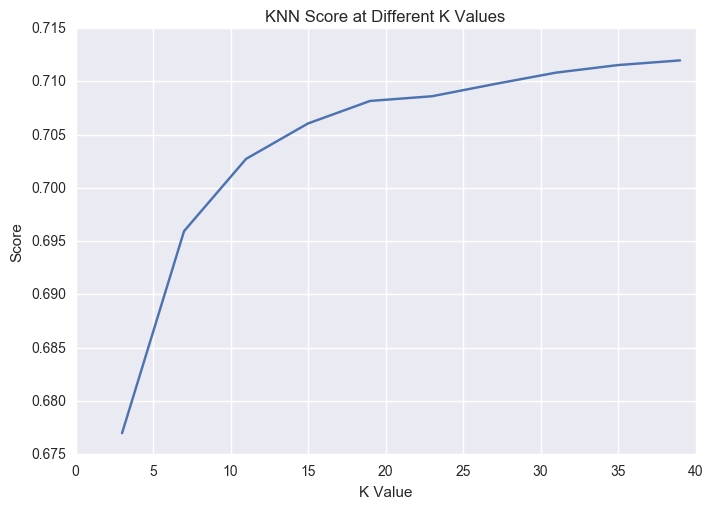

In [30]:
#plots cvv score
plt.plot(range(3,40,4),score)
plt.ylabel('Score')
plt.xlabel('K Value')
plt.title('KNN Score at Different K Values')
plt.show()

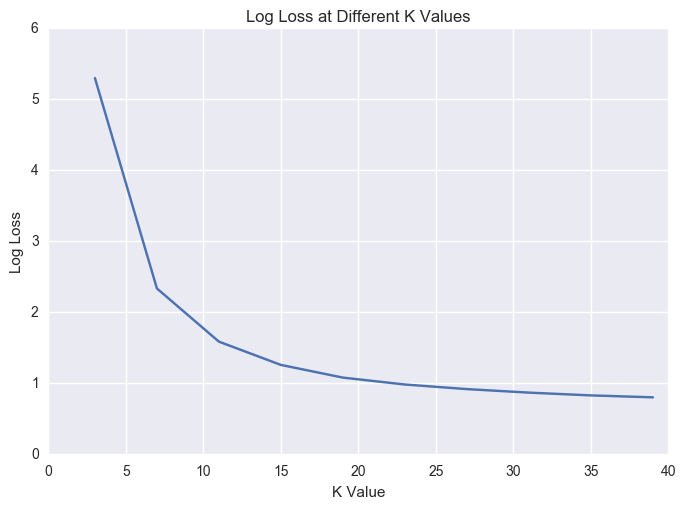

In [31]:
#plots logloss
plt.plot(range(3,40,4),logloss)

plt.ylabel('Log Loss')
plt.xlabel('K Value')
plt.title('Log Loss at Different K Values')
plt.show()